# Universidad Nacional de Córdoba 
# Facultad de Matemática, Astronomía, Física y Computación
# Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones 2022
# Predicción de incidendes viales en la ciudad de Medellin

> Mentora: Isabel Mejia

> Estudiantes: Candela Spitale | Gustavo Venchiarutti | Carina Giovine


Se trabaja con un dataset del portal de datos de la ciudad de Medellin-MEData
[Victimas de Incidentes viales](http://medata.gov.co/dataset/v%C3%ADctimas-en-incidentes-viales)


# TRABAJO PRÁCTICO DE APRENDIZAJE SUPERVISADO
Estamos interesados en predecir la gravedad del incidente. Donde para nuestro dasaset, herido=1 y muerto=0. 

1. Antes de realizar el entrenamiento del modelo, es importante realizar la 
separación de Train(80%) y Test(20%). Esta separación debe estar balanceada , en sexo , condicion y se debe tener en cuenta tambien la fecha. Sobre  el dataset del práctico 2 se inicia la separación.
Les comparto el siguiente link donde se realiza una separacion del dataset teniendo en cuenta la cronologia: [Separación de TRAIN y Test](https://github.com/jfrau/DiploDatos2019/blob/master/mentoria-envios/practico3_Mentoria_FINAL.ipynb)


2. Recuerden que nuestra variable predictora y, o tarjet es la gravedad de incidente, y las otras features pueden ser la edad, condicion, sexo, latitud, longitud. Los invito a que eligan un subconjunto del dataset, que consideren que afectan a la variable gravedad de incidente..

3. Ahora para que modelo que se entrene y tenga resultados confiables, es importante que los datos esten normalizados.  Debemos realizar la normalización de los datos. [Explicacion de normalizacion](https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02)
Acá generamos tambien las nuevas dummy del subconjunto seleccionado.

4. Apliquemos algunos modelos, como la regresión logística, RandomForestclassifier, DecisionTreeClassifier.
Realicemos una comparación de los resultados del modelo normalizado y del modelo sin normalizar?¿ Hay cambios significativos de los hiperparámetros?
Analicemos los hiperpametros de la matriz de confusión,  los errores de cada modelo y comparemos esos errores, Accuracy, las curva ROC y PR, y demás.

Ya hemos aplicado el modelo de Random Forest  ahora analicemos las features mas significativas del modelo  [Analisis de features despues de aplicar random forest](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)

Realizar la presentación del trabajo práctico con un informe, donde el desarrollo este acompañados de un analisis e interpretación de los resultados.

Aquí la aplicación de algunos [modelos simple](https://github.com/Lizzy-Mejia/Prediccion-de-ACV/blob/main/Stroke_Prediction.ipynb)

## 1--> Preparación de Ambiente

In [1]:
!pip install miceforest
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# LIBRERIAS GENERALES Y DE VISUALIZACION
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2
from scipy import stats
import missingno as msno
import json
import sklearn
import h5py
import graphviz
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

# LIBRERIAS PARA IMPUTAR DATOS
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, LabelBinarizer, OneHotEncoder
import miceforest as mf
from sklearn.feature_extraction import DictVectorizer

# LIBRERIAS PARA BALANCEO SEPARACION Y ANALISIS
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report,  mean_squared_error, r2_score, plot_confusion_matrix
from imblearn.over_sampling import RandomOverSampler

# LIBRERIAS PARA PREDICCION DE DATOS
from sklearn import linear_model, neural_network, ensemble
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from xgboost import XGBRegressor, XGBRFRegressor, XGBClassifier, XGBRFClassifier


In [3]:
URL = 'https://drive.google.com/file/d/1Gd_DpdBwd0pxa5sSJ80QU-1LisycZFqh/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+URL.split('/')[-2]
invia_df = pd.read_csv(path, comment="#")

In [4]:
# Convertimos nuevamente el tipo de la variable Fecha_Incidente a datetime que al pasar a csv se transformó a tipo object
invia_df.Fecha_incidente = pd.to_datetime(invia_df.Fecha_incidente, dayfirst=True, format='%Y-%m-%d')
print('Fecha_incidente = {}'.format(invia_df.Fecha_incidente.unique()))

Fecha_incidente = ['2014-01-01T00:00:00.000000000' '2014-01-02T00:00:00.000000000'
 '2014-01-03T00:00:00.000000000' ... '2021-09-28T00:00:00.000000000'
 '2021-09-29T00:00:00.000000000' '2021-09-30T00:00:00.000000000']


##2--> Preparación del Data Set

De acuerdo al trabajo, la variable target es la Gravedad_victima, tenemos que realizar el modelo tratando de predecir si se van producir incidentes con posibilidad de muertes. 

In [5]:
invia_df.isnull().sum()

Gravedad_victima           0
Fecha_incidente            0
Hora_incidente             0
Clase_incidente            0
Direccion_incidente       12
Sexo                       0
Edad                       0
Condicion                  0
Mes                        0
Dia                        0
Num_dia                    1
Hora                       7
Grupo_edad                11
Año                        0
Radicado                  47
Latitud                20494
Longitud               20494
Comuna                 20495
Barrio                 20955
dtype: int64

In [6]:
print("Proporción de valores nulos en Direccion_incidente = {0:.4f}".format(invia_df.Direccion_incidente.isna().sum()/len(invia_df)))
print("Proporción de valores nulos en Edad = {0:.4f}".format(invia_df.Edad.isna().sum()/len(invia_df)))
print("Proporción de valores nulos en Num_dia = {0:.4f}".format(invia_df.Num_dia.isna().sum()/len(invia_df)))
print("Proporción de valores nulos en Hora = {0:.4f}".format(invia_df.Hora.isna().sum()/len(invia_df)))
print("Proporción de valores nulos en Grupo_edad = {0:.4f}".format(invia_df.Grupo_edad.isna().sum()/len(invia_df)))
print("Proporción de valores nulos en Radicado = {0:.4f}".format(invia_df.Radicado.isna().sum()/len(invia_df)))
print("Proporción de valores nulos en Latitud = {0:.4f}".format(invia_df.Latitud.isna().sum()/len(invia_df)))
print("Proporción de valores nulos en Longitud = {0:.4f}".format(invia_df.Longitud.isna().sum()/len(invia_df)))
print("Proporción de valores nulos en Comuna = {0:.4f}".format(invia_df.Comuna.isna().sum()/len(invia_df)))
print("Proporción de valores nulos en Barrio = {0:.4f}".format(invia_df.Barrio.isna().sum()/len(invia_df)))

Proporción de valores nulos en Direccion_incidente = 0.0001
Proporción de valores nulos en Edad = 0.0000
Proporción de valores nulos en Num_dia = 0.0000
Proporción de valores nulos en Hora = 0.0000
Proporción de valores nulos en Grupo_edad = 0.0000
Proporción de valores nulos en Radicado = 0.0002
Proporción de valores nulos en Latitud = 0.0880
Proporción de valores nulos en Longitud = 0.0880
Proporción de valores nulos en Comuna = 0.0880
Proporción de valores nulos en Barrio = 0.0900


Debido a que el data set presenta un porcentaje de datos nulos que no llega al 0.01% del total, eliminaremos los registros nulos.

In [7]:
invia_df = invia_df.dropna(subset=['Latitud'], axis=0)
invia_df.isnull().sum()

Gravedad_victima         0
Fecha_incidente          0
Hora_incidente           0
Clase_incidente          0
Direccion_incidente      6
Sexo                     0
Edad                     0
Condicion                0
Mes                      0
Dia                      0
Num_dia                  1
Hora                     5
Grupo_edad              11
Año                      0
Radicado                43
Latitud                  0
Longitud                 0
Comuna                   2
Barrio                 461
dtype: int64

In [8]:
invia_df = invia_df.dropna(subset=['Barrio'], axis=0)
invia_df.isnull().sum()

Gravedad_victima        0
Fecha_incidente         0
Hora_incidente          0
Clase_incidente         0
Direccion_incidente     6
Sexo                    0
Edad                    0
Condicion               0
Mes                     0
Dia                     0
Num_dia                 1
Hora                    4
Grupo_edad             11
Año                     0
Radicado               40
Latitud                 0
Longitud                0
Comuna                  0
Barrio                  0
dtype: int64

In [9]:
invia_df = invia_df.dropna(axis=0)
invia_df.isnull().sum()

Gravedad_victima       0
Fecha_incidente        0
Hora_incidente         0
Clase_incidente        0
Direccion_incidente    0
Sexo                   0
Edad                   0
Condicion              0
Mes                    0
Dia                    0
Num_dia                0
Hora                   0
Grupo_edad             0
Año                    0
Radicado               0
Latitud                0
Longitud               0
Comuna                 0
Barrio                 0
dtype: int64

### Analisis de Temporalidad
Analizamos la variable de tiempos para ver si es necesario considerar las fechas para balancear la separacion de los datos.

In [10]:
invia_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 211855 entries, 0 to 232869
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Gravedad_victima     211855 non-null  object        
 1   Fecha_incidente      211855 non-null  datetime64[ns]
 2   Hora_incidente       211855 non-null  object        
 3   Clase_incidente      211855 non-null  object        
 4   Direccion_incidente  211855 non-null  object        
 5   Sexo                 211855 non-null  object        
 6   Edad                 211855 non-null  float64       
 7   Condicion            211855 non-null  object        
 8   Mes                  211855 non-null  object        
 9   Dia                  211855 non-null  object        
 10  Num_dia              211855 non-null  float64       
 11  Hora                 211855 non-null  float64       
 12  Grupo_edad           211855 non-null  object        
 13  Año           

In [11]:
invia_df['Fecha_incidente'].groupby(
                          [invia_df['Fecha_incidente'].dt.year.rename('Año'),
                           invia_df['Fecha_incidente'].dt.month.rename('Mes'), 
                           invia_df['Fecha_incidente'].dt.day.rename('Dia')]
                           ).agg({'count'})

count
Año  Mes Dia       
2014 1   1       69
         2       51
         3       62
         4       51
         5       30
...             ...
2021 9   26      40
         27      65
         28      69
         29      88
         30      45

[2830 rows x 1 columns]

In [12]:
# Analisis Detallado
df_mask1 = pd.crosstab(index = invia_df['Año'],
            columns=invia_df['Mes'], margins=True)
df_mask1

Mes,Abr,Ago,Dic,Ene,Feb,Jul,Jun,Mar,May,Nov,Oct,Sept,All
Año,,,,,,,,,,,,,
2014,2306,2500,2294,1925,1871,2509,2419,2290,2435,2248,2281,2468,27546
2015,2363,2693,2478,2206,2353,2549,2246,2542,2530,2351,2540,2622,29473
2016,2564,2858,2248,2234,2533,2667,2495,2580,2529,2539,2613,2777,30637
2017,2232,2622,2301,2187,2424,2435,2317,2399,2331,2281,2338,2526,28393
2018,2204,2138,2210,2063,2076,2311,2263,2353,2300,1925,2226,2053,26122
2019,2039,2780,2710,1995,2071,2593,2100,2063,2213,2634,2835,2875,28908
2020,702,1527,2159,2550,2655,1432,1530,1789,1268,1958,1993,1878,21441
2021,1607,1950,0,1803,2254,2764,2533,2227,2249,0,0,1948,19335
All,16017,19068,16400,16963,18237,19260,17903,18243,17855,15936,16826,19147,211855


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


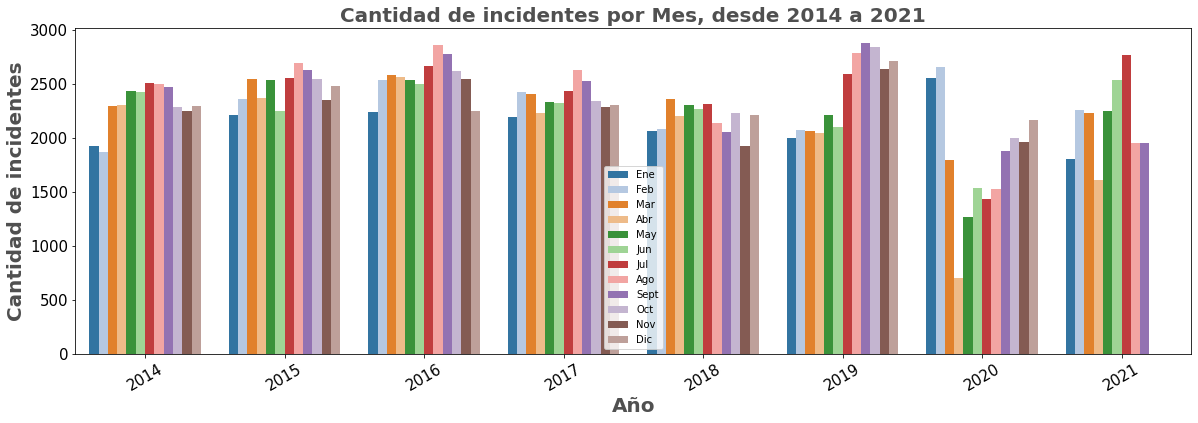

In [13]:
fig = plt.figure(figsize=(20,6))
sns.countplot(invia_df.Año,  hue=invia_df.Mes, palette='tab20')

plt.title('Cantidad de incidentes por Mes, desde 2014 a 2021', 
            loc='center', color='#505050', fontsize=20, fontweight='bold'
)
plt.ylabel("Cantidad de incidentes", size=20, fontweight='bold', color='#505050')
plt.xlabel("Año", size=20, fontweight='bold', color='#505050')

plt.xticks(fontsize=15, rotation=30)
plt.yticks(fontsize=15)

plt.legend(fontsize=10, loc='best')

Realizado el análisis de fechas, vemos que no existe motivo para considear series temporales que puedan afectar la predicción de nuestros modelos, ya que la distribución de la cantidad de incidentes se presenta bastante uniforme.

### Separamos Datos del Target

Sacamos la columna ***Gravedad_victima*** y la colocamos en ***df_result***, porque seria la variable objetivo. 

Dejamos en ***df_train*** los datos con los cuales vamos a entrenar en nuestros modelos.

In [14]:
invia_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 211855 entries, 0 to 232869
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Gravedad_victima     211855 non-null  object        
 1   Fecha_incidente      211855 non-null  datetime64[ns]
 2   Hora_incidente       211855 non-null  object        
 3   Clase_incidente      211855 non-null  object        
 4   Direccion_incidente  211855 non-null  object        
 5   Sexo                 211855 non-null  object        
 6   Edad                 211855 non-null  float64       
 7   Condicion            211855 non-null  object        
 8   Mes                  211855 non-null  object        
 9   Dia                  211855 non-null  object        
 10  Num_dia              211855 non-null  float64       
 11  Hora                 211855 non-null  float64       
 12  Grupo_edad           211855 non-null  object        
 13  Año           

In [15]:
invia_df

,Gravedad_victima,Fecha_incidente,Hora_incidente,Clase_incidente,Direccion_incidente,Sexo,Edad,Condicion,Mes,Dia,Num_dia,Hora,Grupo_edad,Año,Radicado,Latitud,Longitud,Comuna,Barrio
0,Heridos,2014-01-01,00:15:00,Otro,CR 49 CL 72,M,17.0,Motociclista,Ene,Mié,1.0,0.0,10 - 19,2014,1423940.0,6.266915,-75.559099,04 - Aranjuez,Manrique Central No. 1
1,Heridos,2014-01-01,00:30:00,Atropello,CR 46 CL 98,M,20.0,Motociclista,Ene,Mié,1.0,0.0,20 - 29,2014,1423921.0,6.289353,-75.553292,01 - Popular,Moscú No. 2
2,Heridos,2014-01-01,00:30:00,Atropello,CR 46 CL 98,F,18.0,Peatón,Ene,Mié,1.0,0.0,10 - 19,2014,1423921.0,6.289353,-75.553292,01 - Popular,Moscú No. 2
3,Heridos,2014-01-01,00:37:00,Atropello,CL 32 CR 84,M,19.0,Motociclista,Ene,Mié,1.0,0.0,10 - 19,2014,1423849.0,6.234327,-75.607611,16 - Belén,Las Mercedes
4,Heridos,2014-01-01,00:37:00,Atropello,CL 32 CR 84,M,39.0,Peatón,Ene,Mié,1.0,0.0,30 - 39,2014,1423849.0,6.234327,-75.607611,16 - Belén,Las Mercedes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232865,Heridos,2021-09-30,20:00:00,Otro,CL 97 CR 85,F,44.0,Motociclista,Sept,Jue,30.0,20.0,40 - 49,2021,1763939.0,6.298268,-75.585992,06 - Doce de Octubre,Picachito
232866,Heridos,2021-09-30,20:40:00,Choque,CR 48 CL 16 A,F,38.0,Motociclista,Sept,Jue,30.0,20.0,30 - 39,2021,1763788.0,6.217895,-75.575824,14 - El Poblado,Villa Carlota
232867,Heridos,2021-09-30,22:00:00,Otro,CL 54 CR 9 A,M,32.0,Motociclista,Sept,Jue,30.0,22.0,30 - 39,2021,1764135.0,6.234267,-75.536311,08 - Villa Hermosa,Las Estancias
232868,Heridos,2021-09-30,22:00:00,Otro,CL 54 CR 9 A,F,29.0,Acompañante de Motocicleta,Sept,Jue,30.0,22.0,20 - 29,2021,1764135.0,6.234267,-75.536311,08 - Villa Hermosa,Las Estancias


In [16]:
df_target = invia_df.Gravedad_victima
df_train = invia_df.drop('Gravedad_victima',axis=1)
df_target, df_train

(0         Heridos
 1         Heridos
 2         Heridos
 3         Heridos
 4         Heridos
            ...   
 232865    Heridos
 232866    Heridos
 232867    Heridos
 232868    Heridos
 232869    Heridos
 Name: Gravedad_victima, Length: 211855, dtype: object,
        Fecha_incidente Hora_incidente Clase_incidente Direccion_incidente  \
 0           2014-01-01       00:15:00            Otro         CR 49 CL 72   
 1           2014-01-01       00:30:00       Atropello         CR 46 CL 98   
 2           2014-01-01       00:30:00       Atropello         CR 46 CL 98   
 3           2014-01-01       00:37:00       Atropello         CL 32 CR 84   
 4           2014-01-01       00:37:00       Atropello         CL 32 CR 84   
 ...                ...            ...             ...                 ...   
 232865      2021-09-30       20:00:00            Otro         CL 97 CR 85   
 232866      2021-09-30       20:40:00          Choque       CR 48 CL 16 A   
 232867      2021-09-30       22:

### Selección de Datos

En principio, consideraremos como columnas predictoras de interés:

`Clase_incidente`, `Sexo`, `Edad`, `Condicion`, `Mes`, `Dia`, `Num_dia`, `Año`, `Comuna`, `Barrio`.

Por lo cual, eliminamos del Data Set las columnas que **NO** consideramos importantes al momento de realizar los modelos de predicción. 




In [17]:
df_train = df_train.drop(['Fecha_incidente', 'Hora_incidente', 'Direccion_incidente', 'Grupo_edad', 'Hora', 'Radicado', 'Latitud', 'Longitud'], axis=1)

In [18]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 211855 entries, 0 to 232869
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Clase_incidente  211855 non-null  object 
 1   Sexo             211855 non-null  object 
 2   Edad             211855 non-null  float64
 3   Condicion        211855 non-null  object 
 4   Mes              211855 non-null  object 
 5   Dia              211855 non-null  object 
 6   Num_dia          211855 non-null  float64
 7   Año              211855 non-null  int64  
 8   Comuna           211855 non-null  object 
 9   Barrio           211855 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 25.8+ MB


###  Tranformamos Variables

Preparamos el dataframe de datos convirtiendo las variables categóricas a numéricas porque todas las imputaciones y modelos utilizan ese tipo de variables.

In [19]:
# Definimos la lista de valores categoricos que voy a considerar para el analisis
label_cols = []

# Verificamos cuales son las variables OBJECT, veos los valores unicos calculo la cantidad
for var in df_train:
    if df_train[var].dtype == 'object':
        unique_cases = df_train[var].unique()
        # Selecciono las variables categoricas para analizar
        label_cols.append(var)
        print(var)
        print(unique_cases)
        print(len(unique_cases))

# En esta lista estan todas las variables categóricas que vamos a transformar
print('\n\nLas variables categóricas que vamos a considerar son:\n', label_cols)

Clase_incidente
['Otro' 'Atropello' 'Choque' 'Caida Ocupante' 'Volcamiento' 'Incendio']
6
Sexo
['M' 'F' 'Sin Inf']
3
Condicion
['Motociclista' 'Peatón' 'Acompañante de Motocicleta' 'Conductor'
 'Ciclista' 'Pasajero']
6
Mes
['Ene' 'Feb' 'Mar' 'Abr' 'May' 'Jun' 'Jul' 'Ago' 'Sept' 'Oct' 'Nov' 'Dic']
12
Dia
['Mié' 'Jue' 'Vie' 'Sáb' 'Dom' 'Lun' 'Mar']
7
Comuna
['04 - Aranjuez' '01 - Popular' '16 - Belén' '10 - La Candelaria'
 '03 - Manrique' '07 - Robledo' '11 - Laureles Estadio' '14 - El Poblado'
 '15 - Guayabal' '09 - Buenos Aires' '06 - Doce de Octubre'
 '05 - Castilla' '12 - La América' '08 - Villa Hermosa' '13 - San Javier'
 '60 - Corregimiento de San Cristóbal' '02 - Santa Cruz'
 '90 - Corregimiento de Santa Elena' '70 - Corregimiento de Altavista'
 '80 - Corregimiento de San Antonio de Prado'
 '50 - Corregimiento de San Sebastián de Palmitas']
21
Barrio
['Manrique Central No. 1' 'Moscú No. 2' 'Las Mercedes' 'Jesús Nazareno'
 'Manrique Oriental' 'Villa Flora' 'U.D. Atanasio Girardot'


#### LabelEncoder() 

In [20]:
df_LE = df_train.copy()
le = LabelEncoder()

for col in label_cols:
    df_LE[col] = df_LE[col].astype(str)
    df_LE[col] = le.fit_transform(df_LE[col])
df_LE

,Clase_incidente,Sexo,Edad,Condicion,Mes,Dia,Num_dia,Año,Comuna,Barrio
0,4,1,17.0,3,3,4,1.0,2014,3,219
1,0,1,20.0,3,3,4,1.0,2014,0,234
2,0,0,18.0,5,3,4,1.0,2014,0,234
3,0,1,19.0,3,3,4,1.0,2014,15,197
4,0,1,39.0,5,3,4,1.0,2014,15,197
...,...,...,...,...,...,...,...,...,...,...
232865,4,0,44.0,3,11,1,30.0,2021,5,258
232866,2,0,38.0,3,11,1,30.0,2021,13,343
232867,4,1,32.0,3,11,1,30.0,2021,7,192
232868,4,0,29.0,0,11,1,30.0,2021,7,192


In [21]:
df_train

,Clase_incidente,Sexo,Edad,Condicion,Mes,Dia,Num_dia,Año,Comuna,Barrio
0,Otro,M,17.0,Motociclista,Ene,Mié,1.0,2014,04 - Aranjuez,Manrique Central No. 1
1,Atropello,M,20.0,Motociclista,Ene,Mié,1.0,2014,01 - Popular,Moscú No. 2
2,Atropello,F,18.0,Peatón,Ene,Mié,1.0,2014,01 - Popular,Moscú No. 2
3,Atropello,M,19.0,Motociclista,Ene,Mié,1.0,2014,16 - Belén,Las Mercedes
4,Atropello,M,39.0,Peatón,Ene,Mié,1.0,2014,16 - Belén,Las Mercedes
...,...,...,...,...,...,...,...,...,...,...
232865,Otro,F,44.0,Motociclista,Sept,Jue,30.0,2021,06 - Doce de Octubre,Picachito
232866,Choque,F,38.0,Motociclista,Sept,Jue,30.0,2021,14 - El Poblado,Villa Carlota
232867,Otro,M,32.0,Motociclista,Sept,Jue,30.0,2021,08 - Villa Hermosa,Las Estancias
232868,Otro,F,29.0,Acompañante de Motocicleta,Sept,Jue,30.0,2021,08 - Villa Hermosa,Las Estancias


#### LabelBinarizer()

In [22]:
df_LB = df_train.copy()

In [23]:
lb = LabelBinarizer()
# Ordenar el data frame porque LB devuelve un array ordenado alfabeticamente por las opciones de la variable
# Indexar para mantener el orden sino al concatenar los une con dos ordenes de data frame diferentes
df_LB = df_LB.sort_values('Clase_incidente').reset_index()
df_LB['Clase_incidente'] = df_LB['Clase_incidente'].astype(str)
array_result = lb.fit_transform(df_LB[['Clase_incidente']])
# Convertir el resultado en Dataframe, colocar el nombre a las columnas
df_result = pd.DataFrame(array_result, columns=lb.classes_)
# Concatenar el data frame resultante al original
df_LB = pd.concat([df_LB, df_result], axis=1)
# Eliminar las columnas 
df_LB = df_LB.drop(['Clase_incidente', 'index'], axis=1) 
df_LB

,Sexo,Edad,Condicion,Mes,Dia,Num_dia,Año,Comuna,Barrio,Atropello,Caida Ocupante,Choque,Incendio,Otro,Volcamiento
0,M,16.0,Motociclista,Dic,Mié,16.0,2015,11 - Laureles Estadio,U.D. Atanasio Girardot,1,0,0,0,0,0
1,M,86.0,Peatón,Ago,Jue,18.0,2016,11 - Laureles Estadio,El Estadio,1,0,0,0,0,0
2,M,66.0,Peatón,Jul,Mar,28.0,2020,16 - Belén,Fátima,1,0,0,0,0,0
3,M,20.0,Motociclista,Ago,Jue,18.0,2016,11 - Laureles Estadio,El Estadio,1,0,0,0,0,0
4,M,89.0,Peatón,Feb,Vie,27.0,2015,04 - Aranjuez,San Isidro,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211850,M,28.0,Motociclista,Feb,Lun,18.0,2019,13 - San Javier,San Javier No.1,0,0,0,0,0,1
211851,F,49.0,Acompañante de Motocicleta,Feb,Lun,18.0,2019,13 - San Javier,San Javier No.1,0,0,0,0,0,1
211852,F,20.0,Acompañante de Motocicleta,Dic,Mar,29.0,2020,07 - Robledo,López de Mesa,0,0,0,0,0,1
211853,M,24.0,Motociclista,Dic,Mar,29.0,2020,11 - Laureles Estadio,Florida Nueva,0,0,0,0,0,1


In [24]:
lb = LabelBinarizer()
# Ordenar el data frame porque LB devuelve un array ordenado alfabeticamente por las opciones de la variable
# Indexar para mantener el orden sino al concatenar los une con dos ordenes de data frame diferentes
df_LB = df_LB.sort_values('Sexo').reset_index()
df_LB['Sexo'] = df_LB['Sexo'].astype(str)
array_result = lb.fit_transform(df_LB[['Sexo']])
# Convertir el resultado en Dataframe, colocar el nombre a las columnas
df_result = pd.DataFrame(array_result, columns=lb.classes_)
# Concatenar el data frame resultante al original
df_LB = pd.concat([df_LB, df_result], axis=1)
# Eliminar las columnas 
df_LB = df_LB.drop(['Sexo', 'index'], axis=1) 
df_LB

,Edad,Condicion,Mes,Dia,Num_dia,Año,Comuna,Barrio,Atropello,Caida Ocupante,Choque,Incendio,Otro,Volcamiento,F,M,Sin Inf
0,38.0,Acompañante de Motocicleta,Jul,Mié,20.0,2016,05 - Castilla,Caribe,0,0,1,0,0,0,1,0,0
1,28.0,Motociclista,May,Lun,1.0,2017,15 - Guayabal,La Colina,0,0,0,0,1,0,1,0,0
2,42.0,Motociclista,Sept,Vie,11.0,2020,11 - Laureles Estadio,Naranjal,0,0,1,0,0,0,1,0,0
3,30.0,Acompañante de Motocicleta,May,Vie,4.0,2018,06 - Doce de Octubre,Doce de Octubre No.1,0,0,0,0,1,0,1,0,0
4,24.0,Motociclista,May,Mié,5.0,2021,11 - Laureles Estadio,El Velódromo,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211850,36.0,Motociclista,Ago,Sáb,23.0,2014,11 - Laureles Estadio,El Estadio,0,0,1,0,0,0,0,0,1
211851,23.0,Motociclista,Jun,Jue,18.0,2020,10 - La Candelaria,Villa Nueva,0,0,1,0,0,0,0,0,1
211852,21.0,Motociclista,Jul,Vie,12.0,2019,04 - Aranjuez,Berlin,0,0,0,0,0,1,0,0,1
211853,31.0,Motociclista,Mar,Mar,23.0,2021,08 - Villa Hermosa,El Pinal,0,0,0,0,0,1,0,0,1


In [25]:
lb = LabelBinarizer()
# Ordenar el data frame porque LB devuelve un array ordenado alfabeticamente por las opciones de la variable
# Indexar para mantener el orden sino al concatenar los une con dos ordenes de data frame diferentes
df_LB = df_LB.sort_values('Condicion').reset_index()
df_LB['Condicion'] = df_LB['Condicion'].astype(str)
array_result = lb.fit_transform(df_LB[['Condicion']])
# Convertir el resultado en Dataframe, colocar el nombre a las columnas
df_result = pd.DataFrame(array_result, columns=lb.classes_)
# Concatenar el data frame resultante al original
df_LB = pd.concat([df_LB, df_result], axis=1)
# Eliminar las columnas 
df_LB = df_LB.drop(['Condicion', 'index'], axis=1) 
df_LB

,Edad,Mes,Dia,Num_dia,Año,Comuna,Barrio,Atropello,Caida Ocupante,Choque,...,Volcamiento,F,M,Sin Inf,Acompañante de Motocicleta,Ciclista,Conductor,Motociclista,Pasajero,Peatón
0,38.0,Jul,Mié,20.0,2016,05 - Castilla,Caribe,0,0,1,...,0,1,0,0,1,0,0,0,0,0
1,3.0,Feb,Dom,21.0,2016,05 - Castilla,Las Brisas,0,0,1,...,0,0,1,0,1,0,0,0,0,0
2,37.0,Mar,Vie,5.0,2021,15 - Guayabal,Guayabal,0,0,1,...,0,1,0,0,1,0,0,0,0,0
3,27.0,Dic,Sáb,5.0,2020,09 - Buenos Aires,Asomadera No. 2,0,0,0,...,0,0,1,0,1,0,0,0,0,0
4,10.0,Dic,Mié,6.0,2017,07 - Robledo,Aures No. 2,0,0,1,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211850,75.0,Oct,Mar,7.0,2014,10 - La Candelaria,Villa Nueva,1,0,0,...,0,1,0,0,0,0,0,0,0,1
211851,39.0,Ene,Sáb,28.0,2017,10 - La Candelaria,Barrio Colón,1,0,0,...,0,0,1,0,0,0,0,0,0,1
211852,28.0,Jul,Lun,19.0,2021,14 - El Poblado,Los Naranjos,1,0,0,...,0,1,0,0,0,0,0,0,0,1
211853,48.0,Sept,Dom,19.0,2021,03 - Manrique,Versalles No. 1,1,0,0,...,0,0,1,0,0,0,0,0,0,1


In [26]:
lb = LabelBinarizer()
# Ordenar el data frame porque LB devuelve un array ordenado alfabeticamente por las opciones de la variable
# Indexar para mantener el orden sino al concatenar los une con dos ordenes de data frame diferentes
df_LB = df_LB.sort_values('Mes').reset_index()
df_LB['Mes'] = df_LB['Mes'].astype(str)
array_result = lb.fit_transform(df_LB[['Mes']])
# Convertir el resultado en Dataframe, colocar el nombre a las columnas
df_result = pd.DataFrame(array_result, columns=lb.classes_)
# Concatenar el data frame resultante al original
df_LB = pd.concat([df_LB, df_result], axis=1)
# Eliminar las columnas 
df_LB = df_LB.drop(['Mes', 'index'], axis=1) 
df_LB

,Edad,Dia,Num_dia,Año,Comuna,Barrio,Atropello,Caida Ocupante,Choque,Incendio,...,Dic,Ene,Feb,Jul,Jun,Mar,May,Nov,Oct,Sept
0,36.0,Jue,27.0,2017,15 - Guayabal,Campo Amor,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,29.0,Vie,28.0,2017,10 - La Candelaria,Jesús Nazareno,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,25.0,Dom,4.0,2021,11 - Laureles Estadio,U.D. Atanasio Girardot,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,20.0,Vie,7.0,2017,08 - Villa Hermosa,San Miguel,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,51.0,Mié,28.0,2021,14 - El Poblado,Los Naranjos,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211850,21.0,Lun,11.0,2017,07 - Robledo,Aures No.1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
211851,0.0,Jue,24.0,2015,05 - Castilla,Terminal de Transporte,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
211852,45.0,Mar,28.0,2021,10 - La Candelaria,La Candelaria,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
211853,79.0,Dom,14.0,2014,11 - Laureles Estadio,Los Colores,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [27]:
lb = LabelBinarizer()
# Ordenar el data frame porque LB devuelve un array ordenado alfabeticamente por las opciones de la variable
# Indexar para mantener el orden sino al concatenar los une con dos ordenes de data frame diferentes
df_LB = df_LB.sort_values('Dia').reset_index()
df_LB['Dia'] = df_LB['Dia'].astype(str)
array_result = lb.fit_transform(df_LB[['Dia']])
# Convertir el resultado en Dataframe, colocar el nombre a las columnas
df_result = pd.DataFrame(array_result, columns=lb.classes_)
# Concatenar el data frame resultante al original
df_LB = pd.concat([df_LB, df_result], axis=1)
# Eliminar las columnas 
df_LB = df_LB.drop(['Dia', 'index'], axis=1) 
df_LB

,Edad,Num_dia,Año,Comuna,Barrio,Atropello,Caida Ocupante,Choque,Incendio,Otro,...,Nov,Oct,Sept,Dom,Jue,Lun,Mar,Mié,Sáb,Vie
0,20.0,7.0,2014,16 - Belén,Rosales,0,0,1,0,0,...,0,0,1,1,0,0,0,0,0,0
1,21.0,24.0,2018,15 - Guayabal,Parque Juan Pablo II,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
2,35.0,24.0,2018,60 - Corregimiento de San Cristóbal,El Uvito,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
3,21.0,24.0,2018,04 - Aranjuez,Moravia,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,21.0,24.0,2018,10 - La Candelaria,Jesús Nazareno,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211850,23.0,22.0,2017,11 - Laureles Estadio,Carlos E. Restrepo,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
211851,31.0,10.0,2019,04 - Aranjuez,San Isidro,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
211852,26.0,6.0,2016,14 - El Poblado,Barrio Colombia,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
211853,37.0,6.0,2016,10 - La Candelaria,Los Ángeles,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [28]:
lb = LabelBinarizer()
# Ordenar el data frame porque LB devuelve un array ordenado alfabeticamente por las opciones de la variable
# Indexar para mantener el orden sino al concatenar los une con dos ordenes de data frame diferentes
df_LB = df_LB.sort_values('Comuna').reset_index()
df_LB['Comuna'] = df_LB['Comuna'].astype(str)
array_result = lb.fit_transform(df_LB[['Comuna']])
# Convertir el resultado en Dataframe, colocar el nombre a las columnas
df_result = pd.DataFrame(array_result, columns=lb.classes_)
# Concatenar el data frame resultante al original
df_LB = pd.concat([df_LB, df_result], axis=1)
# Eliminar las columnas 
df_LB = df_LB.drop(['Comuna', 'index'], axis=1) 
df_LB

,Edad,Num_dia,Año,Barrio,Atropello,Caida Ocupante,Choque,Incendio,Otro,Volcamiento,...,12 - La América,13 - San Javier,14 - El Poblado,15 - Guayabal,16 - Belén,50 - Corregimiento de San Sebastián de Palmitas,60 - Corregimiento de San Cristóbal,70 - Corregimiento de Altavista,80 - Corregimiento de San Antonio de Prado,90 - Corregimiento de Santa Elena
0,67.0,27.0,2017,San Pablo,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,28.0,7.0,2020,Santo Domingo Savio No. 1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,43.0,14.0,2015,Villa Guadalupe,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,21.0,15.0,2019,Popular,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,42.0,24.0,2017,San Pablo,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211850,56.0,27.0,2017,Piedras Blancas,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
211851,22.0,5.0,2015,Las Palmas,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
211852,25.0,13.0,2020,Suburbano El Cerro,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
211853,30.0,9.0,2014,Suburbano Mirador del Poblado,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [29]:
# utilizamos el LabelEncoder ya que tenemos muchos valores únicos de Barrio como para pasarlos a binario
df_LB['Barrio'] = df_LE['Barrio'].astype(str)
df_LB['Barrio'] = LabelEncoder().fit_transform(df_LE['Barrio'])
df_LB

,Edad,Num_dia,Año,Barrio,Atropello,Caida Ocupante,Choque,Incendio,Otro,Volcamiento,...,12 - La América,13 - San Javier,14 - El Poblado,15 - Guayabal,16 - Belén,50 - Corregimiento de San Sebastián de Palmitas,60 - Corregimiento de San Cristóbal,70 - Corregimiento de Altavista,80 - Corregimiento de San Antonio de Prado,90 - Corregimiento de Santa Elena
0,67.0,27.0,2017,219,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,28.0,7.0,2020,234,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,43.0,14.0,2015,234,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,21.0,15.0,2019,197,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,42.0,24.0,2017,197,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211850,56.0,27.0,2017,258,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
211851,22.0,5.0,2015,343,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
211852,25.0,13.0,2020,192,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
211853,30.0,9.0,2014,192,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


#### GetDummies()

In [30]:
df_target = pd.get_dummies(df_target)
df_target = df_target.drop(columns=['Muertos'])
df_target.rename({'Heridos': 'Gravedad_victima'}, axis=1, inplace=True)
df_target

,Gravedad_victima
0,1
1,1
2,1
3,1
4,1
...,...
232865,1
232866,1
232867,1
232868,1


### Estandarizamos los Datos

Ahora para que el modelo se entrene y tenga resultados confiables, es importante que los datos esten normalizados.  Debemos realizar la normalización de los datos. [Explicacion de normalizacion](https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02)
Acá generamos tambien las nuevas dummy del subconjunto seleccionado.

Aplicamos la funcion ***StandardScaler()*** que es muy utilizada en los procesos de Machine Laerning. Esta funcion elimina la media y escala cada característica/variable a la varianza de la unidad. Esta operación se realiza por características de forma independiente. StandardScaler puede verse influenciado por valores atípicos (si existen en el conjunto de datos), ya que implica la estimación de la media empírica y la desviación estándar de cada característica.


In [31]:
# Como este método genera un arreglo de valores, guardamos las columnas para 
# cargarlas de nuevo en el data frame resultante
x_names = df_LE.columns
array_standard = StandardScaler().fit_transform(df_LE)
# Pasamos el resultado de la estandarizacion al data frame que usaremos
df_train = pd.DataFrame(array_standard, columns=x_names)
df_train

,Clase_incidente,Sexo,Edad,Condicion,Mes,Dia,Num_dia,Año,Comuna,Barrio
0,1.334863,0.621894,-1.067170,0.131382,-0.738142,0.462713,-1.682665,-1.476943,-1.220436,0.410962
1,-1.412857,0.621894,-0.858387,0.131382,-0.738142,0.462713,-1.682665,-1.476943,-1.888394,0.566540
2,-1.412857,-1.467674,-0.997576,1.523321,-0.738142,0.462713,-1.682665,-1.476943,-1.888394,0.566540
3,-1.412857,0.621894,-0.927981,0.131382,-0.738142,0.462713,-1.682665,-1.476943,1.451393,0.182782
4,-1.412857,0.621894,0.463910,1.523321,-0.738142,0.462713,-1.682665,-1.476943,1.451393,0.182782
...,...,...,...,...,...,...,...,...,...,...
211850,1.334863,-1.467674,0.811883,0.131382,1.592829,-1.065554,1.631620,1.702244,-0.775132,0.815464
211851,-0.038997,-1.467674,0.394316,0.131382,1.592829,-1.065554,1.631620,1.702244,1.006088,1.697072
211852,1.334863,0.621894,-0.023252,0.131382,1.592829,-1.065554,1.631620,1.702244,-0.329827,0.130922
211853,1.334863,-1.467674,-0.232035,-1.956527,1.592829,-1.065554,1.631620,1.702244,-0.329827,0.130922


### Balanceo de Data Set

Como vamos a trabajar con un problema de clasificación en donde tenemos que etiquetar entre “Herido” o “Muerto” nos encontramos con que en nuestro conjunto de datos de entrenamiento una de las clases es “minoritaria” es decir, tenemos muy poquitas muestras.Esto provoca un desbalanceo en los datos que utilizaremos para el entrenamiento.

Una de las estrategias para tratar de mejorar la situación es crear muestras sintéticas (no idénticas) utilizando diversos algoritmos que intentan seguir la tendencia del grupo minoritario.
Esto lo logramos con la función RandomOverSampler() que duplicar aleatoriamente los ejemplos en la clase minoritaria.



In [32]:
# Inicialización de los métodos de sobremuestreo
ros = RandomOverSampler()

In [33]:
#ROS. Duplica muestras de la clase menos representadas
df_train, df_target = ros.fit_resample(df_train, df_target)
no_Ros = df_target.sum()
si_Ros = df_target.shape[0]- no_Ros
print('Personas Heridas:',no_Ros ,'Personas Fallecidas:', si_Ros)
df_train.info()

Personas Heridas: Gravedad_victima    210131
dtype: int64 Personas Fallecidas: Gravedad_victima    210131
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420262 entries, 0 to 420261
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Clase_incidente  420262 non-null  float64
 1   Sexo             420262 non-null  float64
 2   Edad             420262 non-null  float64
 3   Condicion        420262 non-null  float64
 4   Mes              420262 non-null  float64
 5   Dia              420262 non-null  float64
 6   Num_dia          420262 non-null  float64
 7   Año              420262 non-null  float64
 8   Comuna           420262 non-null  float64
 9   Barrio           420262 non-null  float64
dtypes: float64(10)
memory usage: 32.1 MB


### Separamos el Data Set

Separamos el data set y lo convertimos en un arreglo para que se pueda aplicar los modelos de análisis, ya que lo utilizan como parámetro de entrada.

In [34]:
y = df_target.to_numpy()
X = df_train.to_numpy()

columns = df_train.columns.to_numpy()

y.shape, X.shape, columns

((420262, 1),
 (420262, 10),
 array(['Clase_incidente', 'Sexo', 'Edad', 'Condicion', 'Mes', 'Dia',
        'Num_dia', 'Año', 'Comuna', 'Barrio'], dtype=object))

In [35]:
# Separamos el dat set balanceado en Entrenamiento y Validacion final
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.9, random_state = 8)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((378235, 10), (42027, 10), (378235, 1), (42027, 1))

In [36]:
# Al data set de Entrenamiento se lo divide nuevamente en Entrenamiento y Test
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.8, random_state = 8)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((302588, 10), (75647, 10), (302588, 1), (75647, 1))

##4--> Planteo de modelos

#### Kernel SuperVectorMachine()

Cambiamos los datos originales aplicandoles diferentes funciones a traves de la funcion Kernel

In [ ]:
clf = sklearn.svm.SVC(C=10, kernel="sigmoid", gamma="auto", random_state=26).fit(X_train, y_train)
print(classification_report(y_test, clf.predict(X_test)))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.54      0.55      0.55     37544
           1       0.55      0.55      0.55     38103

    accuracy                           0.55     75647
   macro avg       0.55      0.55      0.55     75647
weighted avg       0.55      0.55      0.55     75647



In [ ]:
clf = sklearn.svm.SVC(kernel="rbf", gamma="auto", random_state=26).fit(X_train, y_train)
print(classification_report(y_test, clf.predict(X_test)))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     Heridos       0.99      1.00      1.00     42029
     Muertos       0.00      0.00      0.00       342

    accuracy                           0.99     42371
   macro avg       0.50      0.50      0.50     42371
weighted avg       0.98      0.99      0.99     42371



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
clf = sklearn.svm.SVC(C=10, kernel="poly", degree=2, gamma="auto", random_state=26).fit(X_train, y_train)
print(classification_report(y_test, clf.predict(X_test)))

#### Arboles de Desicion

In [37]:
clfs = [DecisionTreeClassifier()]
names = ['Árbol de decisión']

trained_models = []
accuracy_models = []
for clf,name in zip(clfs,names):
    print(name)
    clf.fit(X_train, y_train)
    train_predictions = clf.predict(X_train)
    accuracy = accuracy_score(y_train, train_predictions)
    print(f"Accuracy train {name}: %.2f%%" % (accuracy * 100.0))

    train_predictions = clf.predict(X_test)
    accuracy = accuracy_score(y_test, train_predictions)
    print("Accuracy test {name}: %.2f%%" % (accuracy * 100.0))

    trained_models.append(clf)
    accuracy_models.append(accuracy*100)

Árbol de decisión
Accuracy train Árbol de decisión: 99.94%
Accuracy test {name}: 99.37%


##### Ajuste de Hiperparametros

Realizamos un ajuste de hiperparámetros de los modelos elegidos

In [38]:
grid = GridSearchCV(DecisionTreeClassifier(),
 {'criterion':('gini','entropy'),
 'splitter':("best","random"),
 'max_depth':(10,20,100)})
grid.fit(X_train,y_train)
grid.best_params_

{'criterion': 'gini', 'max_depth': 100, 'splitter': 'best'}

###### Análisis Data Set TEST

Accuracy train Arbol de decisión: 99.94%
Accuracy test Arbol de decisión: 99.40%


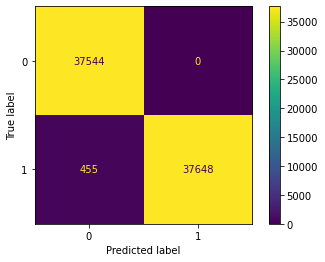

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     37544
           1       1.00      0.99      0.99     38103

    accuracy                           0.99     75647
   macro avg       0.99      0.99      0.99     75647
weighted avg       0.99      0.99      0.99     75647



In [39]:
# Análisis del modelo en TEST
clf = DecisionTreeClassifier(**grid.best_params_).fit(X_train, y_train)

train_predictions = clf.predict(X_train)
accuracy = accuracy_score(y_train, train_predictions)
print("Accuracy train Arbol de decisión: %.2f%%" % (accuracy * 100.0))

test_predictions = clf.predict(X_test)
accuracy = accuracy_score(y_test, test_predictions)
print("Accuracy test Arbol de decisión: %.2f%%" % (accuracy * 100.0))
ConfusionMatrixDisplay.from_predictions(y_test, test_predictions)
plt.show()

print(classification_report(y_test,clf.predict(X_test)))

In [40]:
# Estratificamos el data set de ENTRENAMIENTO
FOLDS=5
cv = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=10)

X_train2 = np.array(X_train)
y_train2 = np.array(y_train)


for clfi, name in zip([DecisionTreeClassifier(**grid.best_params_)],names):
    print(clfi)
    avg_accuracy = 0
    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train2, y_train2)):
        xi, yi = X_train2[train_idx], y_train2[train_idx]
        x_valid, y_valid = X_train2[val_idx], y_train2[val_idx]
        clfi = clfi.fit(xi, yi)

        test_predictions = clfi.predict(x_valid)
        accuracy = accuracy_score(y_valid, test_predictions)
        avg_accuracy +=accuracy
        print(f"Precisión test fold {fold}: {accuracy * 100.0 :.2f}" % ())

    avg_accuracy /= FOLDS
    print(f'Avg. accuracy = {avg_accuracy * 100}')

DecisionTreeClassifier(max_depth=100)
Precisión test fold 0: 99.28
Precisión test fold 1: 99.23
Precisión test fold 2: 99.37
Precisión test fold 3: 99.25
Precisión test fold 4: 99.28
Avg. accuracy = 99.27888736470616


###### Análisis Data Set VALIDACION

Accuracy train Arbol de decisión: 99.94%
Accuracy test Arbol de decisión: 99.41%


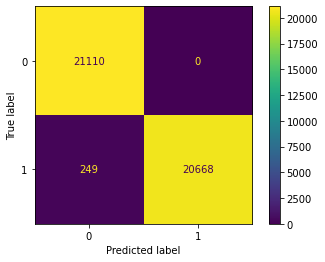

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     21110
           1       1.00      0.99      0.99     20917

    accuracy                           0.99     42027
   macro avg       0.99      0.99      0.99     42027
weighted avg       0.99      0.99      0.99     42027



In [41]:
# Análisis del modelo en VALIDACION
clf = DecisionTreeClassifier(**grid.best_params_).fit(X_train, y_train)

train_predictions = clf.predict(X_train)
accuracy = accuracy_score(y_train, train_predictions)
print("Accuracy train Arbol de decisión: %.2f%%" % (accuracy * 100.0))

val_predictions = clf.predict(X_val)
accuracy = accuracy_score(y_val, val_predictions)
print("Accuracy test Arbol de decisión: %.2f%%" % (accuracy * 100.0))
ConfusionMatrixDisplay.from_predictions(y_val, val_predictions)
plt.show()

print(classification_report(y_val,clf.predict(X_val)))

#### Random Forrest

##### Analisis del Data Set en TEST

In [42]:
# Análisis del modelo en TEST
clf = ensemble.RandomForestClassifier(criterion= "gini", n_estimators=50, random_state=2)
clf.fit(X_train, y_train);
predictions = clf.predict(X_test)
print(classification_report(y_test, predictions))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37544
           1       1.00      1.00      1.00     38103

    accuracy                           1.00     75647
   macro avg       1.00      1.00      1.00     75647
weighted avg       1.00      1.00      1.00     75647



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


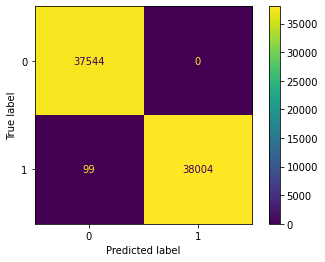

In [43]:
plot_confusion_matrix(clf,X_test,y_test)
plt.show()

In [44]:
feature_imp = pd.Series(clf.feature_importances_,index=columns).sort_values(ascending=False)
feature_imp[:10]

Edad               0.193925
Barrio             0.135496
Clase_incidente    0.120579
Num_dia            0.117378
Condicion          0.101320
Mes                0.088557
Comuna             0.084702
Año                0.072557
Dia                0.063990
Sexo               0.021498
dtype: float64

Hemos aplicado el modelo de Random Forest. 

Analizamos las features mas significativas del modelo.

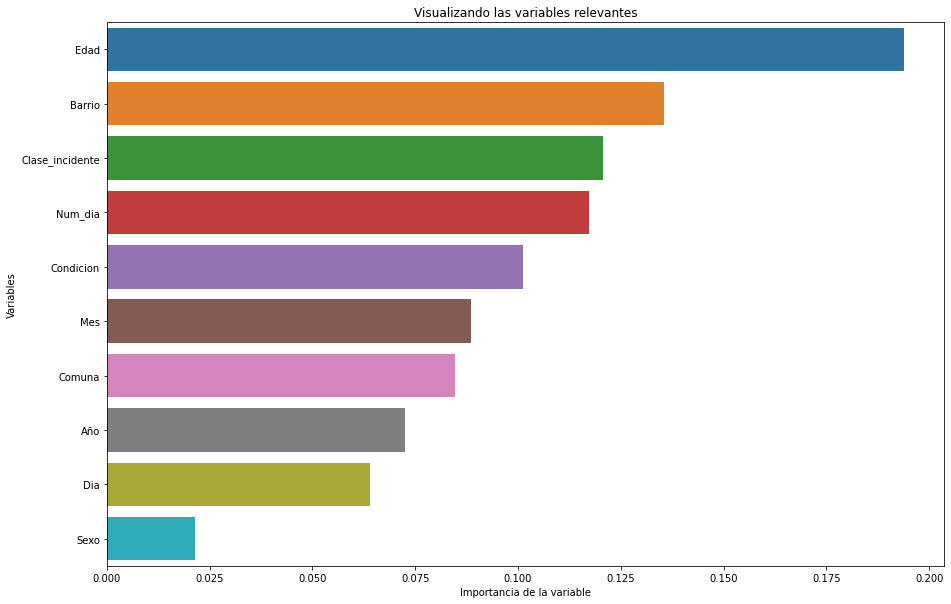

In [45]:
plt.figure(figsize=(15,10))
# creamos el gráfico de barras
sns.barplot(x=feature_imp, y=feature_imp.index)
# agregamos estilo
plt.xlabel('Importancia de la variable')
plt.ylabel('Variables')
plt.title("Visualizando las variables relevantes")

#mostramos y cerramos gráfico
plt.show()

##### Análisis del Dat Set en VALIDACION

In [46]:
# Analisis del modelo en VALIDACION
clf = ensemble.RandomForestClassifier(criterion= "gini", n_estimators=50, random_state=2)
clf.fit(X_train, y_train);
predictions = clf.predict(X_val)
print(classification_report(y_val, predictions))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21110
           1       1.00      1.00      1.00     20917

    accuracy                           1.00     42027
   macro avg       1.00      1.00      1.00     42027
weighted avg       1.00      1.00      1.00     42027



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


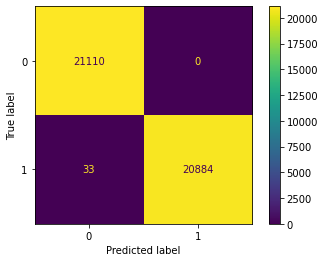

In [47]:
plot_confusion_matrix(clf,X_val,y_val)
plt.show()

#### Boosting

In [48]:
FOLDS=10
cv = KFold(n_splits=FOLDS, shuffle=True, random_state=4)

In [49]:
# sofmax se usa cuando tememos mas de dos resultados o clases
# se debe especificar el número de resultados o clases con el parametro num_class= 2
clfs = [XGBClassifier(objective = "multi:softmax", colsample_bytree = 0.3, learning_rate = 0.1,
                           max_depth = 5, alpha = 10, n_estimators = 10, num_class= 2),
        XGBRFClassifier(objective = "multi:softmax", colsample_bytree = 0.3, learning_rate = 0.1,
                           max_depth = 5, alpha = 10, n_estimators = 10, num_class= 2)]

clfs_names = ['XGBC', 'XGBRFC']

In [50]:
for clf, name in zip(clfs, clfs_names):
    avg_accuracy = 0
    print(name)
    for fold, (train_idx, val_idx) in enumerate(cv.split(X,y)):
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[val_idx], y[val_idx]
        clf.fit(X_train,y_train)
        preds = clf.predict(X_test)
        accuracy = accuracy_score(y_test, preds)
        avg_accuracy +=accuracy
    avg_accuracy /= FOLDS
    print(f'Avg. accuracy = {avg_accuracy * 100}')

XGBC


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), fo

Avg. accuracy = 71.90776239323327
XGBRFC


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), fo

Avg. accuracy = 70.3682493471894


## ***Síntesis del trabajo práctico de Aprendizaje Supervisado***




La mayoría de los datos con los que estamos trabajando son atributos categóricos y por lo tanto fue necesario hacer una codificación numérica de los mismos para que funcionen con los algoritmos de clasificación.

Los datos no están estandarizados, por lo tanto es adecuado que se lleve a cabo una estandarización de los mismos, previo al entrenamiento de los algoritmos. Esto es para que todas las características tengan la misma importancia.  
Estandarizamos con el método `StandardScaler` que nos permite ajustar esos datos a la misma escala.

Como variables predictoras iniciales seleccionamos, variable “X”: (`Sexo`, `Edad`, `Condición`, `Mes`, `Día`, `Num_dia`, `Año`, `Clase_incidente`, `Comuna`, `Barrio`)
La variable “y” objetivo es `Gravedad_victima` que tiene dos valores: herido=1 y muerto=0.

Uno de los desafíos a los que nos enfrentamos fue el desbalanceo de nuestra variable objetivo, por lo cuál tuvimos que generar datos sintéticos para balancear los mismos.
Los datos sintéticos son datos artificialmente generados a partir de los datos originales, pero que mantienen las mismas características estadísticas, informacionales y predictivas.

Luego procedemos a dividir el conjunto de datos en tres: entrenamiento , testeo y validación.

Algunos de los algoritmos que ejecutamos con los datos son:
* `DecisionTreeClassifier`: En los árboles de decisión se realiza un agrupamiento de los datos basándose en los valores de los atributos de los datos que tenemos.
* `RandomForestClassifier`: En este tipo de algoritmos se realiza una búsqueda de un clasificador más preciso con el uso de árboles de decisión.
* `SuperVectorMachine`: Este algoritmo, también llamado abreviadamente SVM, puede ser considerado como una ampliación del Perceptrón. Utiliza como hiperplano un vector de soporte que determina si los ejemplos pertenecen a una u otra clase.

*Métricas*

Se necesita cuantificar el comportamiento que los algoritmos de aprendizaje automático tienen con el conjunto de datos en estudio.

Unas de ellas es `accuracy_score` o precisión, que se encarga de computar la exactitud, ya sea la fracción o el número de ejemplos que se han clasificado correctamente. Si el número de etiquetas conocidas se corresponden con el mismo número de etiquetas predichas entonces tendremos una precisión 1.0. En esta métrica, mejor será nuestro clasificador cuanto más cerca esté del valor 1.0.

Con la métrica `confusion_matrix` mostramos una matriz de confusión y se evalúa como se ha comportado nuestro clasificador. Se muestra de forma visual cómo se ha comportado en una tabla bidimensional donde las filas corresponden a las etiquetas conocidas y las columnas a las que el clasificador ha predicho.

Concluímos que el modelo que presenta mejores métricas ajustándose a los datos de este Data Set con la variable de objetivo, es `RandomForestClassifier`, con un `accuracy_score` de 1 tanto para el conjunto de test como el de validación.